In [48]:
import numpy as np
import pandas as pd
import torch, torch.nn as nn

import data.data_manager as data_manager

In [49]:
def get_action(x, model):
    return model.predict(x)

tree_actions = []

input_vars = ['time',
                'Site Outdoor Air Drybulb Temperature(Environment)',
                'Site Outdoor Air Relative Humidity(Environment)',
                'Site Wind Speed(Environment)',
                'Site Direct Solar Radiation Rate per Area(Environment)',
                'Zone People Occupant Count(SPACE1-1)',
                'Zone Air Temperature(SPACE1-1)']

import pickle
pickle_in = open('decision_tree.pkl', "rb")

model = pickle.loads(pickle_in.read())

env_forecast = data_manager.get_environment_forecast('pittsburgh')

current_step = 0

df = []
while current_step < 96:
    obs = 17

    current_step += 1
    if current_step == 0:
        in_obs = [0, 0, 0, 0, 0, 0, 0]
        # reshape obs to 2D array
        in_obs = np.reshape(in_obs, (1, -1))
        # add feature names to in_obs
        in_obs = pd.DataFrame(in_obs, columns=input_vars)
    else:
        # time is current_step mod 96 times 0.25
        time = (current_step % 96) * 0.25
        # get other variables in input_vars from obs
        in_obs = [time]
        for var in input_vars[1:]:
            if var == 'Zone Air Temperature(SPACE1-1)':
                in_obs.append(obs)
            else:
                in_obs.append(env_forecast.iloc[current_step][var])
        # reshape obs to 2D array
        in_obs = np.reshape(in_obs, (1, -1))
        # add feature names to in_obs
        in_obs = pd.DataFrame(in_obs, columns=input_vars)
    action = get_action(in_obs, model)
    tree_actions.append(action)

tree_actions = np.array(tree_actions)
tree_actions = tree_actions.tolist()
for i in range(len(tree_actions)):
    tree_actions[i] = tree_actions[i][0]
print(tree_actions)

tree_actions = np.array([22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 15.0, 15.0, 16.0, 16.0, 17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 15.0, 17.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 15.0, 15.0, 15.0, 16.0, 15.0, 15.0, 15.0, 21.0, 18.0, 21.0, 22.0, 22.0, 22.0, 22.0, 15.0, 16.0, 22.0, 15.0, 15.0, 22.0, 15.0, 15.0, 22.0, 15.0, 22.0])

[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0]


In [50]:
def model_predict_fn(state_vector, model_path):
    model_demo = nn.Sequential(
        nn.Linear(8, 200),
        nn.SiLU(),
        nn.Linear(200, 200),
        nn.SiLU(),
        nn.Linear(200, 200),
        nn.SiLU(),
        nn.Linear(200, 1),
    )
    model_demo.load_state_dict(torch.load(model_path))
    model_demo.eval()
    prediction = model_demo(torch.tensor(state_vector.astype(np.float32))).detach().numpy()
    return prediction

def choose_action(state, model_predict_fn, horizon, n_samples, environment_forecast, curr_step, model_path, winter=True):

    zone_temperature_matrix = np.zeros((n_samples, horizon+1, 1))
    # populate every n_samples at time 0 with the current zone temperature
    for i in range(n_samples):
        zone_temperature_matrix[i, 0] = state

    action_matrix = np.zeros((n_samples, horizon, 2))

    # populate the action matrix with random integers between 15 and 26 inclusive
    for i in range(n_samples):
        for j in range(horizon):
            action_matrix[i, j, 0] = np.random.randint(21, 30)
            action_matrix[i, j, 1] = np.random.randint(15, 23)

    environment_forecast = environment_forecast[curr_step:curr_step+horizon]

    for t in range(horizon):
        action_vector = action_matrix[:, t]
        zone_temperature_vector = zone_temperature_matrix[:, t]
        environment_forecast_vector = np.tile(environment_forecast.iloc[t], (n_samples, 1))

        state_vector = np.concatenate([environment_forecast_vector, zone_temperature_vector, action_vector], axis=1)

        next_zone_temperature_vector = model_predict_fn(state_vector, model_path)

        zone_temperature_matrix[:, t+1] = next_zone_temperature_vector
    
    zone_temperature_matrix = zone_temperature_matrix[:, 1:]
    
    rewards_vector = evaluate_rewards(zone_temperature_matrix, action_matrix, environment_forecast, winter)

    return action_matrix[np.argmax(rewards_vector), 0]


def evaluate_rewards(zone_temperature_matrix, action_matrix, env_forecast, winter):
    rewards_vector = np.zeros(zone_temperature_matrix.shape[0])
    for trajectory in range(zone_temperature_matrix.shape[0]):
        sum_reward = 0
        for t in range(zone_temperature_matrix.shape[1]):
            # get 'Zone People Occupant Count(SPACE1-1)' in the env_forcast
            people_count = env_forecast.iloc[t].at['Zone People Occupant Count(SPACE1-1)']
            zone_temp = zone_temperature_matrix[trajectory, t]
            action = action_matrix[trajectory, t]
            step_reward = 0
            if people_count > 0:
                if not winter:
                    if zone_temp < 23.0:
                        step_reward += zone_temp - 23.0
                    elif zone_temp > 26.0:
                        step_reward += 26.0 - zone_temp
                else:
                    if zone_temp < 20.0:
                        step_reward += zone_temp - 20.0
                    elif zone_temp > 23.5:
                        step_reward += 23.5 - zone_temp
            else:
                if not winter:
                    step_reward -= abs(30-action[0]) # 30 means no cooling applied
                else:
                    step_reward -= abs(action[1]-15) # 15 means no heating applied
            sum_reward += 0.99**t*step_reward
        if type(sum_reward) == np.ndarray:
            rewards_vector[trajectory] += sum_reward[0]
        elif type(sum_reward) == np.float64:
            rewards_vector[trajectory] += sum_reward
    return rewards_vector

In [51]:
def run_experiment(n_samples, horizon, path, winter=True):

    env_forecast = data_manager.get_environment_forecast('pittsburgh')

    current_step = 0

    df = []
    while current_step < 96:
        obs = 17

        current_step += 1
        for _ in range(30):
            action = choose_action(obs, model_predict_fn, horizon, n_samples, env_forecast, curr_step=current_step, model_path=path, winter=winter)
            df.append([obs, action[1], current_step])
            print(action, ' :: ', current_step)
        df_csv = pd.DataFrame(df, columns=['obs', 'action', 'step'])
        df_csv.to_csv('Jan1_pittsburgh.csv')
    df_csv = pd.DataFrame(df, columns=['obs', 'action', 'step'])
    df_csv.to_csv('Jan1_pittsburgh.csv')

In [52]:
# run_experiment(1000, 
#                20, 
#                'zmodels/model_pittsburgh_winter_1200.pth', 
#                winter=True)

In [53]:
import torch, torch.nn as nn

df = pd.read_csv('Jan1_pittsburgh.csv')

# drop the first column
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['obs'])

print(df.head())
print(df.shape)

   action  step
0    17.0     1
1    18.0     1
2    19.0     1
3    15.0     1
4    16.0     1
(2880, 2)


In [54]:
# '''
# plot df as a line
# x axis: step
# y axis: distribution of action
# fill between two variance
# '''

# # new array
# step_action = np.zeros((30, 96))

# # iterate rows through df
# current_row = 0
# current_step = 0
# for index, row in df.iterrows():
#     if row['step'] != current_step:
#         current_row = 0
#         current_step = row['step']
#     step_action[current_row, int(current_step-1)] += row['action']
#     current_row += 1

# step_action = [[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 15.0, 22.00000000000001, 16.0, 16.0, 16.0, 16.0, 17.0, 15.0, 20.0, 16.0, 17.0, 17.0, 15.0, 15.0, 17.0, 18.0, 16.0, 16.0, 17.0, 17.0, 17.0, 15.0, 17.0, 15.0, 19.0, 20.0, 15.0, 18.0, 19.0, 15.0, 16.0, 15.0, 15.0, 15.0, 15.0, 17.0, 17.0, 20.0, 16.0, 20.0, 18.0, 18.0, 19.0, 22.0, 18.0, 22.0, 15.0, 16.0, 20.0, 20.0, 22.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 16.0, 15.0, 16.0, 15.0, 16.0, 21.0, 20.0, 15.0, 19.0, 17.0, 15.0, 15.0, 15.0, 19.0, 15.0, 18.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 16.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 15.0, 18.0, 15.0, 17.0, 20.0, 22.0, 16.0, 17.0, 18.0, 17.0, 18.0, 21.0, 18.0, 21.0, 22.0, 18.0, 21.0, 20.0, 18.0, 22.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 17.0, 16.0, 16.0, 15.0, 19.0, 16.0, 20.0, 19.0, 19.0, 15.0, 17.0, 18.0, 15.0, 17.0, 15.0, 16.0, 19.0, 16.0, 15.0, 16.0, 19.0, 16.0, 18.0, 21.0, 17.0, 15.0, 17.0, 18.0, 15.0, 17.0, 16.0, 17.0, 18.0, 20.0, 21.0, 18.0, 22.0, 17.0, 21.0, 22.0, 20.0, 22.0, 19.0, 16.0, 19.0, 15.0, 19.0, 15.0, 22.00000000000004, 18.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 19.0, 22.00000000000001, 19.0, 20.0, 16.0, 16.0, 17.0, 16.0, 17.0, 16.0, 16.0, 15.0, 16.0, 17.0, 15.0, 19.0, 15.0, 15.0, 19.0, 16.0, 16.0, 15.0, 17.0, 15.0, 15.0, 20.0, 18.0, 16.0, 16.0, 15.0, 15.0, 19.0, 15.0, 15.0, 18.0, 17.0, 18.0, 16.0, 18.0, 22.0, 19.0, 21.0, 16.0, 18.0, 16.0, 17.0, 18.0, 20.0, 20.0, 19.0, 22.00000000000004, 19.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 19.0, 22.00000000000001, 15.0, 16.0, 15.0, 18.0, 19.0, 15.0, 15.0, 20.0, 18.0, 16.0, 15.0, 15.0, 16.0, 20.0, 15.0, 19.0, 15.0, 17.0, 15.0, 19.0, 15.0, 19.0, 15.0, 15.0, 15.0, 17.0, 18.0, 15.0, 17.0, 18.0, 15.0, 16.0, 15.0, 19.0, 17.0, 22.0, 20.0, 15.0, 17.0, 16.0, 15.0, 17.0, 16.0, 22.0, 18.0, 18.0, 19.0, 15.0, 22.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 15.0, 22.00000000000001, 16.0, 20.0, 19.0, 18.0, 17.0, 18.0, 20.0, 18.0, 16.0, 15.0, 15.0, 18.0, 18.0, 16.0, 17.0, 15.0, 17.0, 16.0, 18.0, 17.0, 17.0, 15.0, 17.0, 15.0, 16.0, 17.0, 17.0, 18.0, 15.0, 17.0, 20.0, 21.0, 16.0, 17.0, 15.0, 18.0, 21.0, 17.0, 19.0, 21.0, 16.0, 16.0, 20.0, 18.0, 16.0, 15.0, 21.0, 15.0, 18.0, 22.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 17.0, 16.0, 15.0, 19.0, 15.0, 20.0, 15.0, 16.0, 18.0, 18.0, 17.0, 16.0, 15.0, 19.0, 18.0, 20.0, 16.0, 17.0, 17.0, 15.0, 17.0, 16.0, 19.0, 15.0, 17.0, 16.0, 15.0, 16.0, 19.0, 15.0, 19.0, 16.0, 15.0, 17.0, 18.0, 19.0, 15.0, 22.0, 19.0, 18.0, 22.0, 15.0, 15.0, 19.0, 22.0, 16.0, 18.0, 20.0, 22.0, 17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 17.0, 22.00000000000001, 16.0, 18.0, 16.0, 16.0, 19.0, 19.0, 15.0, 17.0, 16.0, 19.0, 19.0, 15.0, 20.0, 16.0, 20.0, 16.0, 16.0, 17.0, 15.0, 15.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 16.0, 15.0, 20.0, 15.0, 15.0, 18.0, 22.0, 15.0, 22.0, 16.0, 18.0, 21.0, 17.0, 19.0, 20.0, 21.0, 21.0, 22.0, 20.0, 20.0, 19.0, 17.0, 22.0, 19.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 20.0, 18.0, 18.0, 20.0, 19.0, 15.0, 16.0, 15.0, 15.0, 18.0, 15.0, 15.0, 15.0, 17.0, 15.0, 20.0, 21.0, 15.0, 15.0, 15.0, 16.0, 18.0, 15.0, 18.0, 20.0, 16.0, 15.0, 17.0, 15.0, 17.0, 15.0, 15.0, 15.0, 17.0, 20.0, 18.0, 22.0, 19.0, 16.0, 20.0, 19.0, 22.0, 20.0, 19.0, 22.0, 22.0, 19.0, 19.0, 16.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
# [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 16.0, 18.0, 16.0, 19.0, 15.0, 15.0, 17.0, 17.0, 21.0, 16.0, 15.0, 16.0, 15.0, 20.0, 17.0, 16.0, 21.0, 17.0, 21.0, 18.0, 15.0, 19.0, 15.0, 15.0, 16.0, 16.0, 16.0, 17.0, 15.0, 15.0, 16.0, 20.0, 18.0, 22.0, 20.0, 21.0, 16.0, 16.0, 17.0, 21.0, 19.0, 22.0, 18.0, 15.0, 22.0, 19.0, 20.0, 19.0, 22.0, 18.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]]

# n = 54

# tree_actions = tree_actions[32:]
# for i in range(len(step_action)):
#     step_action[i] = step_action[i][32:]

# tree_actions = tree_actions[:n]
# for i in range(len(step_action)):
#     step_action[i] = step_action[i][:n]

# step_action = np.array(step_action)

# # save step action to csv
# step_action_csv = pd.DataFrame(step_action)

# step_action_csv.to_csv('step_action.csv')


# import matplotlib.pyplot as plt

# fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(15, 9), gridspec_kw={'width_ratios': [3, 1]})

# font_size = 24

# ax11.plot(step_action.mean(axis=0), label='mean')

# ax21.plot(tree_actions, label='mean')


# ax11.fill_between(range(n), 
#                  step_action.mean(axis=0)-step_action.std(axis=0), 
#                  step_action.mean(axis=0)+step_action.std(axis=0), 
#                  alpha=0.5, label='1*std')
# ax11.legend(loc='upper left', fontsize=font_size)

# # set xlim and ylim for ax1
# ax11.set_xlim(0, n)
# ax11.set_ylim(14.5, 22.5)

# # set xlim and ylim for ax1
# ax21.set_xlim(0, n)
# ax21.set_ylim(14.5, 22.5)

# # set xticks and yticks for ax1
# ax11.set_xticks(np.arange(0, n, 16), ['8:00',  '12:00', 
#                                      '16:00',  '20:00',], fontsize=font_size)
# ax11.set_yticks(np.arange(15, 23, 1), np.arange(15, 23, 1),fontsize=font_size)

# # set xticks and yticks for ax1
# ax21.set_xticks(np.arange(0, n, 16), ['8:00',  '12:00', 
#                                      '16:00',  '20:00',], fontsize=font_size)
# ax21.set_yticks(np.arange(15, 23, 1), np.arange(15, 23, 1),fontsize=font_size)

# # set xlabel and ylabel for ax1
# # ax11.set_xlabel('Time', fontsize=font_size)
# ax11.set_ylabel('Heating setpoint', fontsize=font_size)

# ax21.set_xlabel('Time', fontsize=font_size)
# ax21.set_ylabel('Heating setpoint', fontsize=font_size)

# ax11.set_title('Existing method\'s behavior', fontsize=font_size+6)

# ax21.set_title('Improved behavior (ours)', fontsize=font_size+6)

# # plot a histogram for the probabilities of actions at time step 60
# time_step = 38

# # draw a rectangle at the location of this time step, height spans the whole y axis
# ax11.add_patch(plt.Rectangle((time_step-0.5, 14.5), 0.1, 8, fill=True, alpha=1, color='gray'))
# # ax11.add_patch(plt.Rectangle((time_step-0.5, 15), 1, 7, fill=True, alpha=0.1, color='k'))
# ax21.add_patch(plt.Rectangle((time_step-0.5, 14.5), 0.1, 8, fill=True, alpha=1, color='gray'))


# actions = step_action[:, time_step-1]
# print(actions)

# ax12.hist(actions, density=True, label='histogram', bins=10, rwidth=0.8)

# tree_segment = tree_actions[time_step]

# ax22.hist([tree_segment], density=True, label='histogram', bins=1, rwidth=0.6)

# ax22.set_xlim(14.5, 22.5)

# # xticks and yticks fontsize for ax2
# ax12.tick_params(axis='both', which='major', labelsize=font_size)
# ax22.tick_params(axis='both', which='major', labelsize=font_size)

# # xlabel and ylabel for ax2
# # ax12.set_xlabel('Heating setpoint', fontsize=font_size)
# ax22.set_xlabel('Heating setpoint', fontsize=font_size)
# ax12.set_ylabel('Probability', fontsize=font_size)
# ax22.set_ylabel('Probability', fontsize=font_size)

# plt.tight_layout()
# # save as pdf
# plt.savefig('figures/Jan1_pittsburgh.pdf', dpi=300)

[17. 22. 21. 18. 17. 15. 18. 22. 20. 20.]


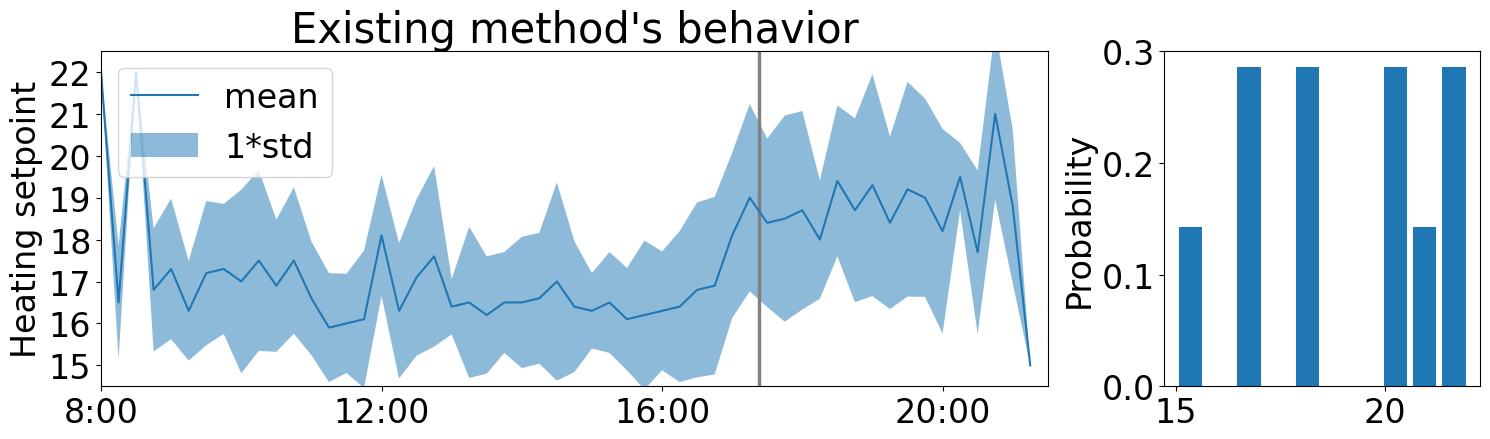

In [55]:
'''
plot df as a line
x axis: step
y axis: distribution of action
fill between two variance
'''

# new array
step_action = np.zeros((30, 96))

# iterate rows through df
current_row = 0
current_step = 0
for index, row in df.iterrows():
    if row['step'] != current_step:
        current_row = 0
        current_step = row['step']
    step_action[current_row, int(current_step-1)] += row['action']
    current_row += 1

step_action = [[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 15.0, 22.00000000000001, 16.0, 16.0, 16.0, 16.0, 17.0, 15.0, 20.0, 16.0, 17.0, 17.0, 15.0, 15.0, 17.0, 18.0, 16.0, 16.0, 17.0, 17.0, 17.0, 15.0, 17.0, 15.0, 19.0, 20.0, 15.0, 18.0, 19.0, 15.0, 16.0, 15.0, 15.0, 15.0, 15.0, 17.0, 17.0, 20.0, 16.0, 20.0, 18.0, 18.0, 19.0, 22.0, 18.0, 22.0, 15.0, 16.0, 20.0, 20.0, 22.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 16.0, 15.0, 16.0, 15.0, 16.0, 21.0, 20.0, 15.0, 19.0, 17.0, 15.0, 15.0, 15.0, 19.0, 15.0, 18.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 16.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 15.0, 18.0, 15.0, 17.0, 20.0, 22.0, 16.0, 17.0, 18.0, 17.0, 18.0, 21.0, 18.0, 21.0, 22.0, 18.0, 21.0, 20.0, 18.0, 22.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 17.0, 16.0, 16.0, 15.0, 19.0, 16.0, 20.0, 19.0, 19.0, 15.0, 17.0, 18.0, 15.0, 17.0, 15.0, 16.0, 19.0, 16.0, 15.0, 16.0, 19.0, 16.0, 18.0, 21.0, 17.0, 15.0, 17.0, 18.0, 15.0, 17.0, 16.0, 17.0, 18.0, 20.0, 21.0, 18.0, 22.0, 17.0, 21.0, 22.0, 20.0, 22.0, 19.0, 16.0, 19.0, 15.0, 19.0, 15.0, 22.00000000000004, 18.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 19.0, 22.00000000000001, 19.0, 20.0, 16.0, 16.0, 17.0, 16.0, 17.0, 16.0, 16.0, 15.0, 16.0, 17.0, 15.0, 19.0, 15.0, 15.0, 19.0, 16.0, 16.0, 15.0, 17.0, 15.0, 15.0, 20.0, 18.0, 16.0, 16.0, 15.0, 15.0, 19.0, 15.0, 15.0, 18.0, 17.0, 18.0, 16.0, 18.0, 22.0, 19.0, 21.0, 16.0, 18.0, 16.0, 17.0, 18.0, 20.0, 20.0, 19.0, 22.00000000000004, 19.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 19.0, 22.00000000000001, 15.0, 16.0, 15.0, 18.0, 19.0, 15.0, 15.0, 20.0, 18.0, 16.0, 15.0, 15.0, 16.0, 20.0, 15.0, 19.0, 15.0, 17.0, 15.0, 19.0, 15.0, 19.0, 15.0, 15.0, 15.0, 17.0, 18.0, 15.0, 17.0, 18.0, 15.0, 16.0, 15.0, 19.0, 17.0, 22.0, 20.0, 15.0, 17.0, 16.0, 15.0, 17.0, 16.0, 22.0, 18.0, 18.0, 19.0, 15.0, 22.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 15.0, 22.00000000000001, 16.0, 20.0, 19.0, 18.0, 17.0, 18.0, 20.0, 18.0, 16.0, 15.0, 15.0, 18.0, 18.0, 16.0, 17.0, 15.0, 17.0, 16.0, 18.0, 17.0, 17.0, 15.0, 17.0, 15.0, 16.0, 17.0, 17.0, 18.0, 15.0, 17.0, 20.0, 21.0, 16.0, 17.0, 15.0, 18.0, 21.0, 17.0, 19.0, 21.0, 16.0, 16.0, 20.0, 18.0, 16.0, 15.0, 21.0, 15.0, 18.0, 22.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 17.0, 16.0, 15.0, 19.0, 15.0, 20.0, 15.0, 16.0, 18.0, 18.0, 17.0, 16.0, 15.0, 19.0, 18.0, 20.0, 16.0, 17.0, 17.0, 15.0, 17.0, 16.0, 19.0, 15.0, 17.0, 16.0, 15.0, 16.0, 19.0, 15.0, 19.0, 16.0, 15.0, 17.0, 18.0, 19.0, 15.0, 22.0, 19.0, 18.0, 22.0, 15.0, 15.0, 19.0, 22.0, 16.0, 18.0, 20.0, 22.0, 17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 17.0, 22.00000000000001, 16.0, 18.0, 16.0, 16.0, 19.0, 19.0, 15.0, 17.0, 16.0, 19.0, 19.0, 15.0, 20.0, 16.0, 20.0, 16.0, 16.0, 17.0, 15.0, 15.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 16.0, 15.0, 20.0, 15.0, 15.0, 18.0, 22.0, 15.0, 22.0, 16.0, 18.0, 21.0, 17.0, 19.0, 20.0, 21.0, 21.0, 22.0, 20.0, 20.0, 19.0, 17.0, 22.0, 19.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 20.0, 18.0, 18.0, 20.0, 19.0, 15.0, 16.0, 15.0, 15.0, 18.0, 15.0, 15.0, 15.0, 17.0, 15.0, 20.0, 21.0, 15.0, 15.0, 15.0, 16.0, 18.0, 15.0, 18.0, 20.0, 16.0, 15.0, 17.0, 15.0, 17.0, 15.0, 15.0, 15.0, 17.0, 20.0, 18.0, 22.0, 19.0, 16.0, 20.0, 19.0, 22.0, 20.0, 19.0, 22.0, 22.0, 19.0, 19.0, 16.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 16.0, 18.0, 16.0, 19.0, 15.0, 15.0, 17.0, 17.0, 21.0, 16.0, 15.0, 16.0, 15.0, 20.0, 17.0, 16.0, 21.0, 17.0, 21.0, 18.0, 15.0, 19.0, 15.0, 15.0, 16.0, 16.0, 16.0, 17.0, 15.0, 15.0, 16.0, 20.0, 18.0, 22.0, 20.0, 21.0, 16.0, 16.0, 17.0, 21.0, 19.0, 22.0, 18.0, 15.0, 22.0, 19.0, 20.0, 19.0, 22.0, 18.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]]

n = 54

# tree_actions = tree_actions[32:]
for i in range(len(step_action)):
    step_action[i] = step_action[i][32:]

# tree_actions = tree_actions[:n]
for i in range(len(step_action)):
    step_action[i] = step_action[i][:n]

step_action = np.array(step_action)

# save step action to csv
step_action_csv = pd.DataFrame(step_action)

step_action_csv.to_csv('step_action.csv')


import matplotlib.pyplot as plt

fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(15, 4.5), gridspec_kw={'width_ratios': [3, 1]})

font_size = 24

ax11.plot(step_action.mean(axis=0), label='mean')

ax11.fill_between(range(n), 
                 step_action.mean(axis=0)-step_action.std(axis=0), 
                 step_action.mean(axis=0)+step_action.std(axis=0), 
                 alpha=0.5, label='1*std')
ax11.legend(loc='upper left', fontsize=font_size)

# set xlim and ylim for ax1
ax11.set_xlim(0, n)
ax11.set_ylim(14.5, 22.5)

# set xticks and yticks for ax1
ax11.set_xticks(np.arange(0, n, 16), ['8:00',  '12:00', 
                                     '16:00',  '20:00',], fontsize=font_size)
ax11.set_yticks(np.arange(15, 23, 1), np.arange(15, 23, 1),fontsize=font_size)

# set xlabel and ylabel for ax1
# ax11.set_xlabel('Time', fontsize=font_size)
ax11.set_ylabel('Heating setpoint', fontsize=font_size)

ax11.set_title('Existing method\'s behavior', fontsize=font_size+6)


# plot a histogram for the probabilities of actions at time step 60
time_step = 38

# draw a rectangle at the location of this time step, height spans the whole y axis
ax11.add_patch(plt.Rectangle((time_step-0.5, 14.5), 0.1, 8, fill=True, alpha=1, color='gray'))
# ax11.add_patch(plt.Rectangle((time_step-0.5, 15), 1, 7, fill=True, alpha=0.1, color='k'))


actions = step_action[:, time_step-1]
print(actions)

ax12.hist(actions, density=True, label='histogram', bins=10, rwidth=0.8)

# xticks and yticks fontsize for ax2
ax12.tick_params(axis='both', which='major', labelsize=font_size)

# xlabel and ylabel for ax2
# ax12.set_xlabel('Heating setpoint', fontsize=font_size)
ax12.set_ylabel('Probability', fontsize=font_size)

plt.tight_layout()
# save as pdf
plt.savefig('figures/Jan1_pittsburgh.pdf', dpi=300)

[17. 22. 21. 18. 17. 15. 18. 22. 20. 20.]


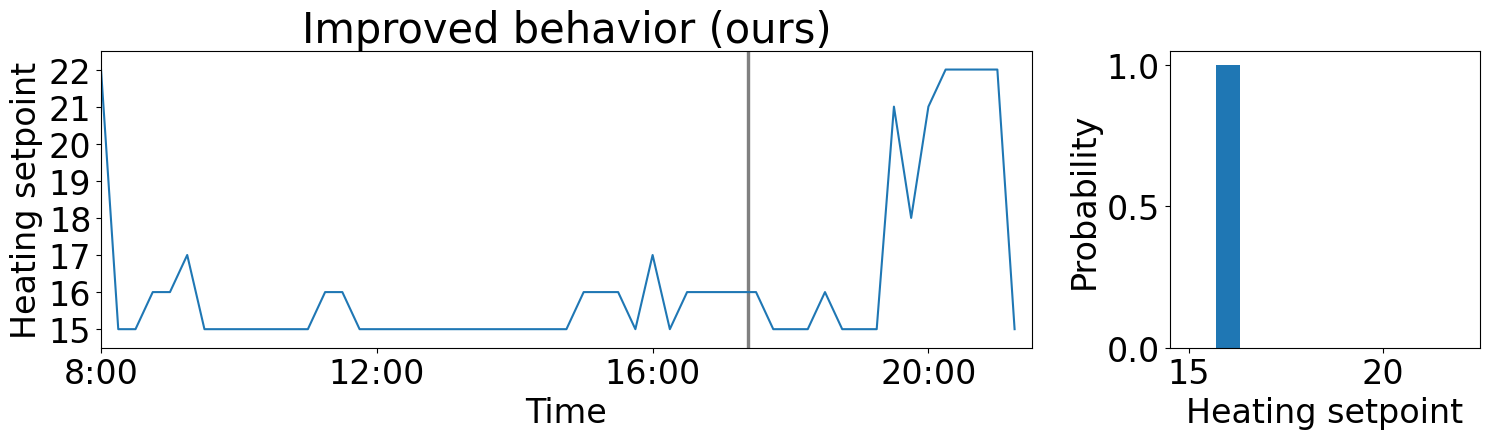

In [56]:
'''
plot df as a line
x axis: step
y axis: distribution of action
fill between two variance
'''

# new array
step_action = np.zeros((30, 96))

# iterate rows through df
current_row = 0
current_step = 0
for index, row in df.iterrows():
    if row['step'] != current_step:
        current_row = 0
        current_step = row['step']
    step_action[current_row, int(current_step-1)] += row['action']
    current_row += 1

step_action = [[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 15.0, 22.00000000000001, 16.0, 16.0, 16.0, 16.0, 17.0, 15.0, 20.0, 16.0, 17.0, 17.0, 15.0, 15.0, 17.0, 18.0, 16.0, 16.0, 17.0, 17.0, 17.0, 15.0, 17.0, 15.0, 19.0, 20.0, 15.0, 18.0, 19.0, 15.0, 16.0, 15.0, 15.0, 15.0, 15.0, 17.0, 17.0, 20.0, 16.0, 20.0, 18.0, 18.0, 19.0, 22.0, 18.0, 22.0, 15.0, 16.0, 20.0, 20.0, 22.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 16.0, 15.0, 16.0, 15.0, 16.0, 21.0, 20.0, 15.0, 19.0, 17.0, 15.0, 15.0, 15.0, 19.0, 15.0, 18.0, 15.0, 16.0, 16.0, 17.0, 17.0, 17.0, 16.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 15.0, 18.0, 15.0, 17.0, 20.0, 22.0, 16.0, 17.0, 18.0, 17.0, 18.0, 21.0, 18.0, 21.0, 22.0, 18.0, 21.0, 20.0, 18.0, 22.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 17.0, 16.0, 16.0, 15.0, 19.0, 16.0, 20.0, 19.0, 19.0, 15.0, 17.0, 18.0, 15.0, 17.0, 15.0, 16.0, 19.0, 16.0, 15.0, 16.0, 19.0, 16.0, 18.0, 21.0, 17.0, 15.0, 17.0, 18.0, 15.0, 17.0, 16.0, 17.0, 18.0, 20.0, 21.0, 18.0, 22.0, 17.0, 21.0, 22.0, 20.0, 22.0, 19.0, 16.0, 19.0, 15.0, 19.0, 15.0, 22.00000000000004, 18.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 19.0, 22.00000000000001, 19.0, 20.0, 16.0, 16.0, 17.0, 16.0, 17.0, 16.0, 16.0, 15.0, 16.0, 17.0, 15.0, 19.0, 15.0, 15.0, 19.0, 16.0, 16.0, 15.0, 17.0, 15.0, 15.0, 20.0, 18.0, 16.0, 16.0, 15.0, 15.0, 19.0, 15.0, 15.0, 18.0, 17.0, 18.0, 16.0, 18.0, 22.0, 19.0, 21.0, 16.0, 18.0, 16.0, 17.0, 18.0, 20.0, 20.0, 19.0, 22.00000000000004, 19.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 19.0, 22.00000000000001, 15.0, 16.0, 15.0, 18.0, 19.0, 15.0, 15.0, 20.0, 18.0, 16.0, 15.0, 15.0, 16.0, 20.0, 15.0, 19.0, 15.0, 17.0, 15.0, 19.0, 15.0, 19.0, 15.0, 15.0, 15.0, 17.0, 18.0, 15.0, 17.0, 18.0, 15.0, 16.0, 15.0, 19.0, 17.0, 22.0, 20.0, 15.0, 17.0, 16.0, 15.0, 17.0, 16.0, 22.0, 18.0, 18.0, 19.0, 15.0, 22.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 15.0, 22.00000000000001, 16.0, 20.0, 19.0, 18.0, 17.0, 18.0, 20.0, 18.0, 16.0, 15.0, 15.0, 18.0, 18.0, 16.0, 17.0, 15.0, 17.0, 16.0, 18.0, 17.0, 17.0, 15.0, 17.0, 15.0, 16.0, 17.0, 17.0, 18.0, 15.0, 17.0, 20.0, 21.0, 16.0, 17.0, 15.0, 18.0, 21.0, 17.0, 19.0, 21.0, 16.0, 16.0, 20.0, 18.0, 16.0, 15.0, 21.0, 15.0, 18.0, 22.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 17.0, 16.0, 15.0, 19.0, 15.0, 20.0, 15.0, 16.0, 18.0, 18.0, 17.0, 16.0, 15.0, 19.0, 18.0, 20.0, 16.0, 17.0, 17.0, 15.0, 17.0, 16.0, 19.0, 15.0, 17.0, 16.0, 15.0, 16.0, 19.0, 15.0, 19.0, 16.0, 15.0, 17.0, 18.0, 19.0, 15.0, 22.0, 19.0, 18.0, 22.0, 15.0, 15.0, 19.0, 22.0, 16.0, 18.0, 20.0, 22.0, 17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 17.0, 22.00000000000001, 16.0, 18.0, 16.0, 16.0, 19.0, 19.0, 15.0, 17.0, 16.0, 19.0, 19.0, 15.0, 20.0, 16.0, 20.0, 16.0, 16.0, 17.0, 15.0, 15.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 16.0, 15.0, 20.0, 15.0, 15.0, 18.0, 22.0, 15.0, 22.0, 16.0, 18.0, 21.0, 17.0, 19.0, 20.0, 21.0, 21.0, 22.0, 20.0, 20.0, 19.0, 17.0, 22.0, 19.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 20.0, 18.0, 18.0, 20.0, 19.0, 15.0, 16.0, 15.0, 15.0, 18.0, 15.0, 15.0, 15.0, 17.0, 15.0, 20.0, 21.0, 15.0, 15.0, 15.0, 16.0, 18.0, 15.0, 18.0, 20.0, 16.0, 15.0, 17.0, 15.0, 17.0, 15.0, 15.0, 15.0, 17.0, 20.0, 18.0, 22.0, 19.0, 16.0, 20.0, 19.0, 22.0, 20.0, 19.0, 22.0, 22.0, 19.0, 19.0, 16.0, 20.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0],
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 22.00000000000004, 21.99999999999999, 16.0, 22.00000000000001, 16.0, 18.0, 16.0, 19.0, 15.0, 15.0, 17.0, 17.0, 21.0, 16.0, 15.0, 16.0, 15.0, 20.0, 17.0, 16.0, 21.0, 17.0, 21.0, 18.0, 15.0, 19.0, 15.0, 15.0, 16.0, 16.0, 16.0, 17.0, 15.0, 15.0, 16.0, 20.0, 18.0, 22.0, 20.0, 21.0, 16.0, 16.0, 17.0, 21.0, 19.0, 22.0, 18.0, 15.0, 22.0, 19.0, 20.0, 19.0, 22.0, 18.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]]

n = 54

tree_actions = tree_actions[32:]
for i in range(len(step_action)):
    step_action[i] = step_action[i][32:]

tree_actions = tree_actions[:n]
for i in range(len(step_action)):
    step_action[i] = step_action[i][:n]

step_action = np.array(step_action)

# save step action to csv
step_action_csv = pd.DataFrame(step_action)

step_action_csv.to_csv('step_action.csv')


import matplotlib.pyplot as plt

fig, (ax21, ax22) = plt.subplots(1, 2, figsize=(15, 4.5), gridspec_kw={'width_ratios': [3, 1]})

font_size = 24

ax21.plot(tree_actions, label='mean')


# set xlim and ylim for ax1
ax21.set_xlim(0, n)
ax21.set_ylim(14.5, 22.5)
# set xticks and yticks for ax1
ax21.set_xticks(np.arange(0, n, 16), ['8:00',  '12:00', 
                                     '16:00',  '20:00',], fontsize=font_size)
ax21.set_yticks(np.arange(15, 23, 1), np.arange(15, 23, 1),fontsize=font_size)

ax21.set_xlabel('Time', fontsize=font_size)
ax21.set_ylabel('Heating setpoint', fontsize=font_size)

ax21.set_title('Improved behavior (ours)', fontsize=font_size+6)

# plot a histogram for the probabilities of actions at time step 60
time_step = 38

ax21.add_patch(plt.Rectangle((time_step-0.5, 14.5), 0.1, 8, fill=True, alpha=1, color='gray'))


actions = step_action[:, time_step-1]
print(actions)

tree_segment = tree_actions[time_step]

ax22.hist([tree_segment], density=True, label='histogram', bins=1, rwidth=0.6)

ax22.set_xlim(14.5, 22.5)

ax22.tick_params(axis='both', which='major', labelsize=font_size)

# xlabel and ylabel for ax2
# ax12.set_xlabel('Heating setpoint', fontsize=font_size)
ax22.set_xlabel('Heating setpoint', fontsize=font_size)
ax22.set_ylabel('Probability', fontsize=font_size)

plt.tight_layout()
# save as pdf
plt.savefig('figures/Jan1_pittsburgh_ours.pdf', dpi=300)